In [109]:
import pandas as pd

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

In [194]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


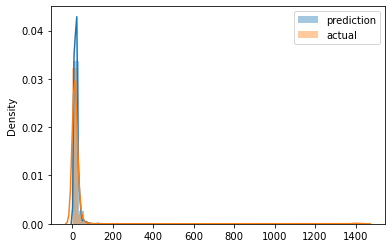

In [210]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

93.9230669493993

In [180]:
def read_dataframe(url):
    df = pd.read_parquet(url)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df[((df.duration >=1) & (df.duration <=60))]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [181]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')

In [182]:
len(df_train), len(df_val)

(48326, 46621)

In [199]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [200]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration,PU_DO
0,2,2025-02-01 00:12:15,2025-02-01 00:15:48,N,1.0,166,41,1.0,0.65,6.50,...,0.00,NaN,1.0,10.80,1.0,1.0,0.00,0.00,3.550000,166_41
1,2,2025-01-31 23:57:05,2025-02-01 00:24:24,N,1.0,255,161,1.0,6.57,31.70,...,0.00,NaN,1.0,37.70,2.0,1.0,2.75,0.75,27.316667,255_161
2,2,2025-02-01 00:24:26,2025-02-01 00:49:54,N,1.0,75,182,2.0,8.36,36.60,...,0.00,NaN,1.0,39.10,2.0,1.0,0.00,0.00,25.466667,75_182
3,1,2025-02-01 00:17:15,2025-02-01 00:25:56,N,1.0,97,209,1.0,2.40,12.80,...,0.00,NaN,1.0,22.55,1.0,1.0,2.75,0.75,8.683333,97_209
4,2,2025-02-01 00:17:36,2025-02-01 00:26:36,N,1.0,7,223,1.0,1.31,10.70,...,0.00,NaN,1.0,15.84,1.0,1.0,0.00,0.00,9.000000,7_223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46616,2,2025-02-28 22:35:00,2025-02-28 23:10:00,None,NaN,181,161,NaN,8.23,44.39,...,0.00,NaN,1.0,56.80,NaN,NaN,NaN,0.75,35.000000,181_161
46617,2,2025-02-28 23:40:00,2025-02-28 23:55:00,None,NaN,166,141,NaN,4.10,27.67,...,0.00,NaN,1.0,38.30,NaN,NaN,NaN,0.00,15.000000,166_141
46618,2,2025-02-28 23:34:00,2025-02-28 23:48:00,None,NaN,41,48,NaN,4.09,27.71,...,0.00,NaN,1.0,32.71,NaN,NaN,NaN,0.75,14.000000,41_48
46619,2,2025-02-28 23:52:00,2025-03-01 00:05:00,None,NaN,75,140,NaN,2.25,16.64,...,0.00,NaN,1.0,21.89,NaN,NaN,NaN,0.00,13.000000,75_140


In [202]:
categorical = ['PU_DO']#'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [203]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [204]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

95.65188295877692

In [209]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

95.52929085621838

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)